Loaded 400000 word vectors!

=== Run 1/10 ===
Sampled 50 words for this run.
Iteration 100/1000, started from '57.26', converged to 'benchmarks'
Iteration 200/1000, started from 'front-page', converged to 'front-page'
Iteration 300/1000, started from '16-strong', converged to '16-strong'
Iteration 400/1000, started from 'fancifully', converged to 'lenses'
Iteration 500/1000, started from 'eupator', converged to 'eupator'
Iteration 600/1000, started from 'tanrikulu', converged to 'tanrikulu'
Iteration 700/1000, started from 'nazli', converged to 'priede'
Iteration 800/1000, started from '57.26', converged to 'lenses'
Iteration 900/1000, started from 'lenses', converged to 'lenses'
Iteration 1000/1000, started from 'compson', converged to 'compson'
Final run: Started from noisy 'mere' — converged closest to: 'virsa'
Final run: Started from noisy 'lenses' — converged closest to: 'lenses'
Final run: Started from noisy 'collingridge' — converged closest to: 'virsa'
Final run: Started from n

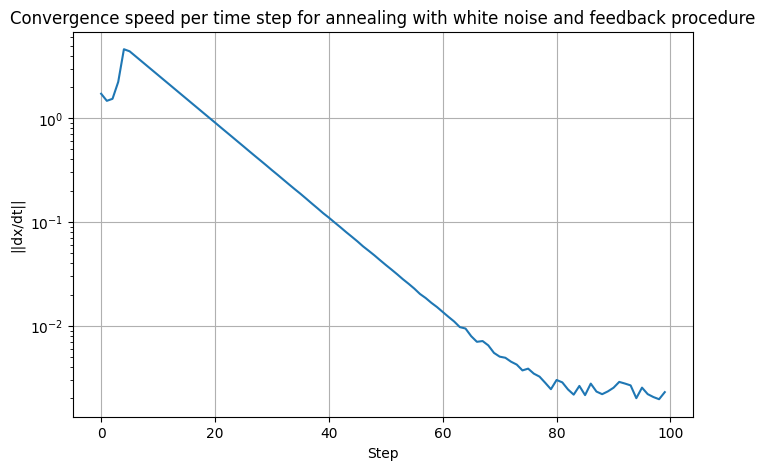

C:\Users\hhl222\AppData\Local\Temp\ipykernel_14708\3839716265.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='small')


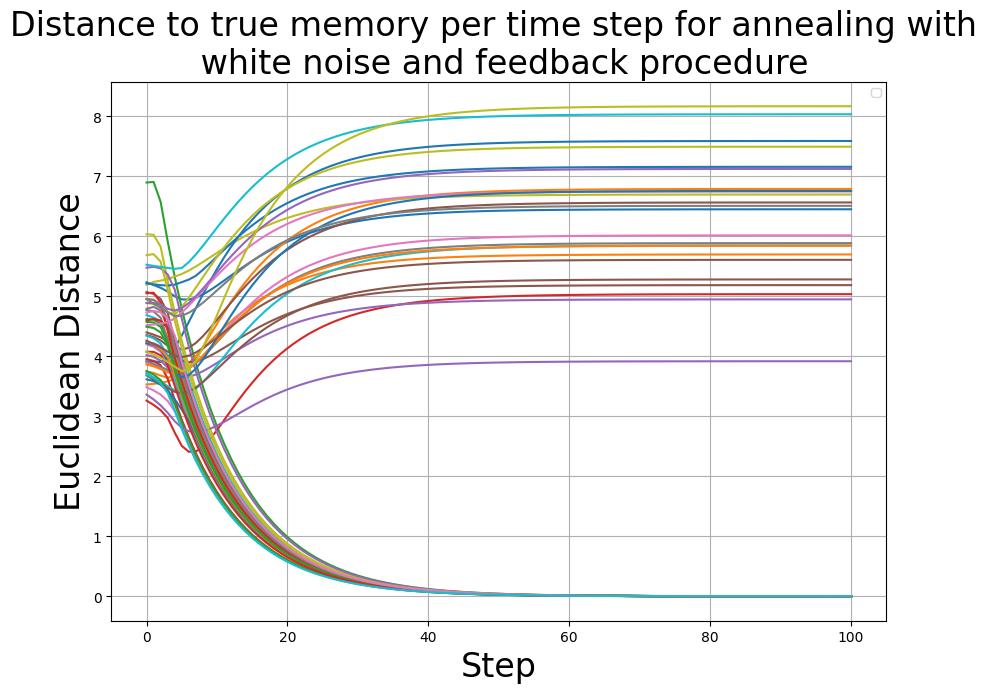

C:\Users\hhl222\AppData\Local\Temp\ipykernel_14708\3839716265.py:129: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', K)
C:\Users\hhl222\AppData\Local\Temp\ipykernel_14708\3839716265.py:141: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize='small', ncol=2)


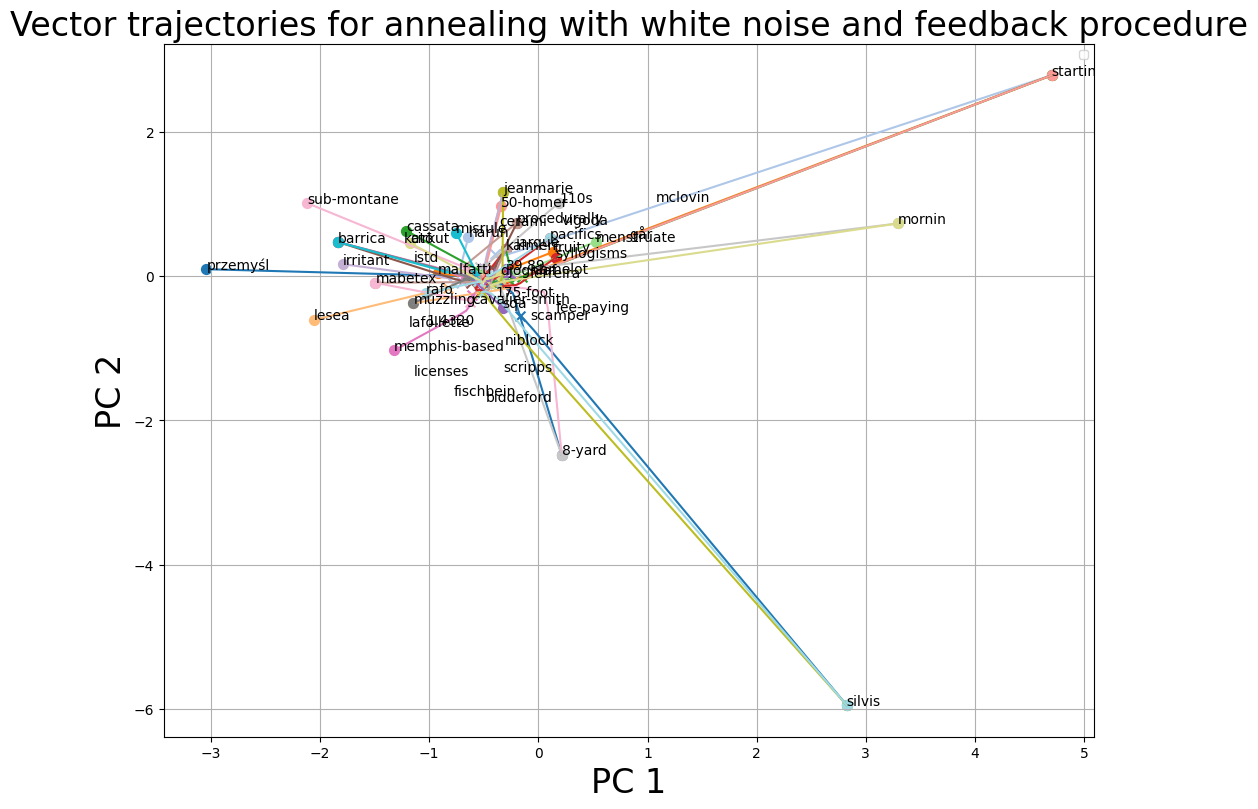

C:\Users\hhl222\AppData\Local\Temp\ipykernel_14708\3839716265.py:161: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='small', ncol=2)


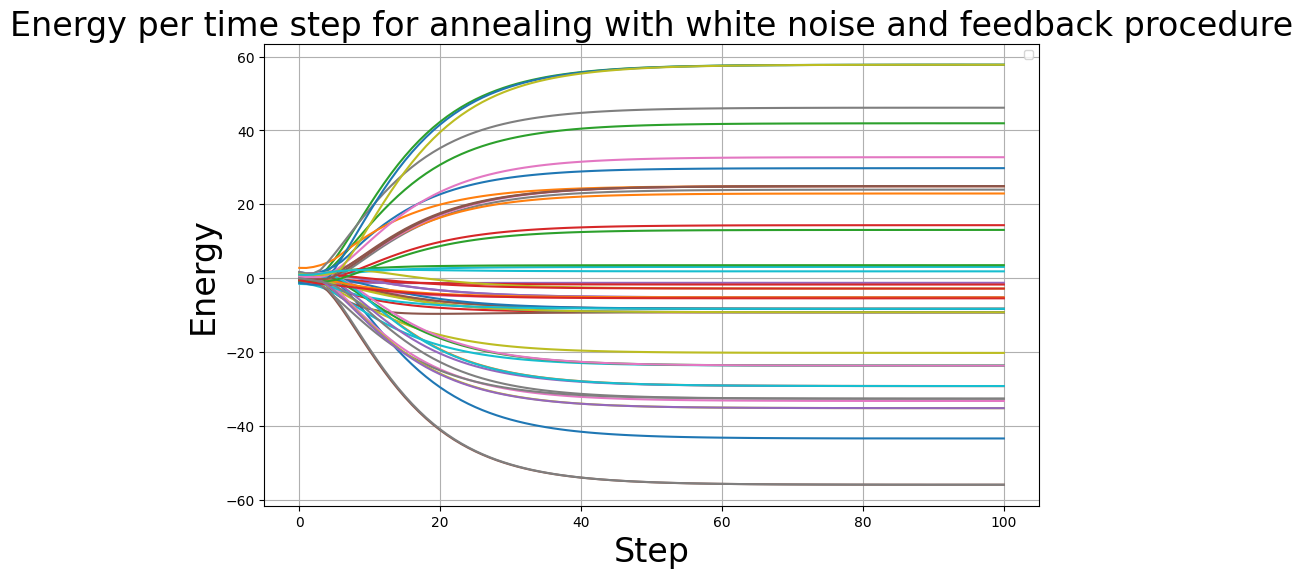

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import random

# Load GloVe vectors (adjust path as needed)
glove_path = 'C:\\Users\\hhl222\\Downloads\\glove.6B.50d.txt'

word_vectors = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        word_vectors[word] = vector
print(f"Loaded {len(word_vectors)} word vectors!")

# Softmax function (numerically stable)
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

def anneal_hopfield_euler_maruyama(Xi, initial_x, w, steps=1000, beta_max=100, dt=0.1, sigma_noise=1e-4):
    N = Xi.shape[1]
    x = initial_x.copy()
    trajectory = [x.copy()]
    for t in range(steps):
        beta = beta_max * (t / steps)
        logits = beta * (Xi @ x) + beta * w
        p = softmax(logits)
        x_dot = Xi.T @ p - x
        noise = sigma_noise * np.sqrt(dt) * np.random.randn(N)
        x_new = x + dt * x_dot + noise
        trajectory.append(x_new.copy())
        x = x_new
    return np.array(trajectory)

def find_closest(x, Xi, word_list):
    sims = (Xi @ x) / (np.linalg.norm(Xi, axis=1) * np.linalg.norm(x) + 1e-8)
    idx = np.argmax(sims)
    return word_list[idx], idx

def run_annealing_all_words_with_noise_and_feedback(
    Xi, subset_words, steps=1000, beta_max=100, dt=0.1,
    noise_level=1.5, sigma_noise=1e-4,
    epsilon=0.01, feedback_iterations=1000
):
    K, N = Xi.shape
    w = np.zeros(K)
    trajectories = []
    final_words = []
    success_count = 0
    all_distances = np.zeros((K, steps+1))
    for iter in range(feedback_iterations):
        i = np.random.randint(K)
        w[i] += epsilon
        noisy_start = Xi[i] + noise_level * np.random.randn(N)
        traj = anneal_hopfield_euler_maruyama(
            Xi, noisy_start, w, steps=steps, beta_max=beta_max, dt=dt,
            sigma_noise=sigma_noise
        )
        final_x = traj[-1]
        closest_word, j = find_closest(final_x, Xi, subset_words)
        if i == j:
            w[i] += epsilon
        else:
            w[j] -= epsilon
        w -= np.mean(w)
        if (iter + 1) % 100 == 0 or iter == feedback_iterations - 1:
            print(f"Iteration {iter+1}/{feedback_iterations}, started from '{subset_words[i]}', converged to '{closest_word}'")
    for i in range(K):
        noisy_start = Xi[i] + noise_level * np.random.randn(N)
        noisy_start /= np.linalg.norm(noisy_start)
        traj = anneal_hopfield_euler_maruyama(
            Xi, noisy_start, w, steps=steps, beta_max=beta_max, dt=dt,
            sigma_noise=sigma_noise
        )
        trajectories.append(traj)
        for t in range(traj.shape[0]):
            all_distances[i, t] = np.linalg.norm(traj[t] - Xi[i])
        final_x = traj[-1]
        closest_word, _ = find_closest(final_x, Xi, subset_words)
        final_words.append(closest_word)
        if closest_word == subset_words[i]:
            success_count += 1
        print(f"Final run: Started from noisy '{subset_words[i]}' — converged closest to: '{closest_word}'")
    success_rate = success_count / K
    print(f"\nFinal success rate: {success_rate*100:.1f}%")
    return np.array(trajectories, dtype=object), final_words, success_rate, all_distances, w

def plot_convergence_norm(trajectory, dt=0.1):
    dx_norms = [np.linalg.norm(trajectory[i+1] - trajectory[i]) / dt for i in range(len(trajectory)-1)]
    plt.figure(figsize=(8, 5))
    plt.plot(dx_norms)
    plt.yscale('log')
    plt.xlabel('Step')
    plt.ylabel('||dx/dt||')
    plt.title('Convergence speed per time step for annealing with white noise and feedback procedure')
    plt.grid(True)
    plt.show()

def plot_euclidean_distances(all_distances, subset_words, word_indices=None):
    plt.figure(figsize=(10, 7))
    time = np.arange(all_distances.shape[1])
    if word_indices is None:
        word_indices = range(len(subset_words))
    for i in word_indices:
        plt.plot(time, all_distances[i])
    plt.xlabel("Step", fontsize=24)
    plt.ylabel("Euclidean Distance", fontsize=24)
    plt.title("Distance to true memory per time step for annealing with \n white noise and feedback procedure", fontsize=24)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.show()

def plot_trajectories_with_targets(all_trajectories, Xi, subset_words):
    all_points = np.vstack([traj for traj in all_trajectories if traj.shape[0] > 0])
    pca = PCA(n_components=2)
    all_points_2d = pca.fit_transform(all_points)
    trajectories_2d = []
    start = 0
    for traj in all_trajectories:
        end = start + traj.shape[0]
        trajectories_2d.append(all_points_2d[start:end])
        start = end
    plt.figure(figsize=(12, 9))
    K = len(all_trajectories)
    colors = cm.get_cmap('tab20', K)
    for idx, traj_2d in enumerate(trajectories_2d):
        c = colors(idx)
        plt.plot(traj_2d[:, 0], traj_2d[:, 1], color=c)
        plt.scatter(traj_2d[0, 0], traj_2d[0, 1], c=[c], marker='x', s=50)
        plt.scatter(traj_2d[-1, 0], traj_2d[-1, 1], c=[c], marker='o', s=50)
    memories_2d = pca.transform(Xi)
    for i, word in enumerate(subset_words):
        plt.annotate(word, (memories_2d[i, 0], memories_2d[i, 1]), fontsize=10, color='black')
    plt.xlabel('PC 1', fontsize=24)
    plt.ylabel('PC 2', fontsize=24)
    plt.title('Vector trajectories for annealing with white noise and feedback procedure', fontsize=24)
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.grid(True)
    plt.show()

# New functions to compute and plot energy
def compute_energy(trajectory, Xi, w):
    energies = []
    for x in trajectory:
        energy = - x @ (Xi.T @ x + w)
        energies.append(energy)
    return np.array(energies)

def plot_all_energies_over_time(all_trajectories, Xi, w):
    plt.figure(figsize=(10, 6))
    for i, traj in enumerate(all_trajectories):
        energies = compute_energy(traj, Xi, w)
        plt.plot(energies)
    plt.xlabel('Step', fontsize=24)
    plt.ylabel('Energy', fontsize=24)
    plt.title('Energy per time step for annealing with white noise and feedback procedure', fontsize=24)
    plt.legend(fontsize='small', ncol=2)
    plt.grid(True)
    plt.show()

# === RUN 10 TIMES AND AVERAGE ===
num_runs = 10
success_rates = []

for run_i in range(num_runs):
    print(f"\n=== Run {run_i+1}/{num_runs} ===")
    all_words = list(word_vectors.keys())
    # Sample 50 words *inside* the loop
    subset_words = random.sample(all_words, 50)
    Xi = np.stack([word_vectors[word] for word in subset_words])
    print(f"Sampled {len(subset_words)} words for this run.")
    
    trajectories, final_words, success_rate, all_distances, w = run_annealing_all_words_with_noise_and_feedback(
        Xi, subset_words, steps=100, beta_max=100, dt=0.1,
        noise_level=1.5, sigma_noise=1e-4,
        epsilon=0.01, feedback_iterations=1000
    )
    success_rates.append(success_rate)

avg_success_rate = np.mean(success_rates)
print(f"\nAverage success rate over {num_runs} runs: {avg_success_rate*100:.2f}%")

# Plot results for last run only
plot_convergence_norm(trajectories[0], dt=0.1)
plot_euclidean_distances(all_distances, subset_words)
plot_trajectories_with_targets(trajectories, Xi, subset_words)
plot_all_energies_over_time(trajectories, Xi, w)
